In [2]:
#setups

import sklearn
import numpy as np
import os
import tarfile
import urllib.request
import pandas as pd

#matplotlib setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [3]:
#Fetch data
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()



In [5]:
#Load_data

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


housing = load_housing_data()

In [8]:
#Quick view
housing.head()

#10 columns

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
#Looking at data structure

housing.info()

#total_bedroom contains null data

#All numerical values except ocean_proximity. Data from a csv => it is text attribute

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
#leaning on ocean_proximity attribute


housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

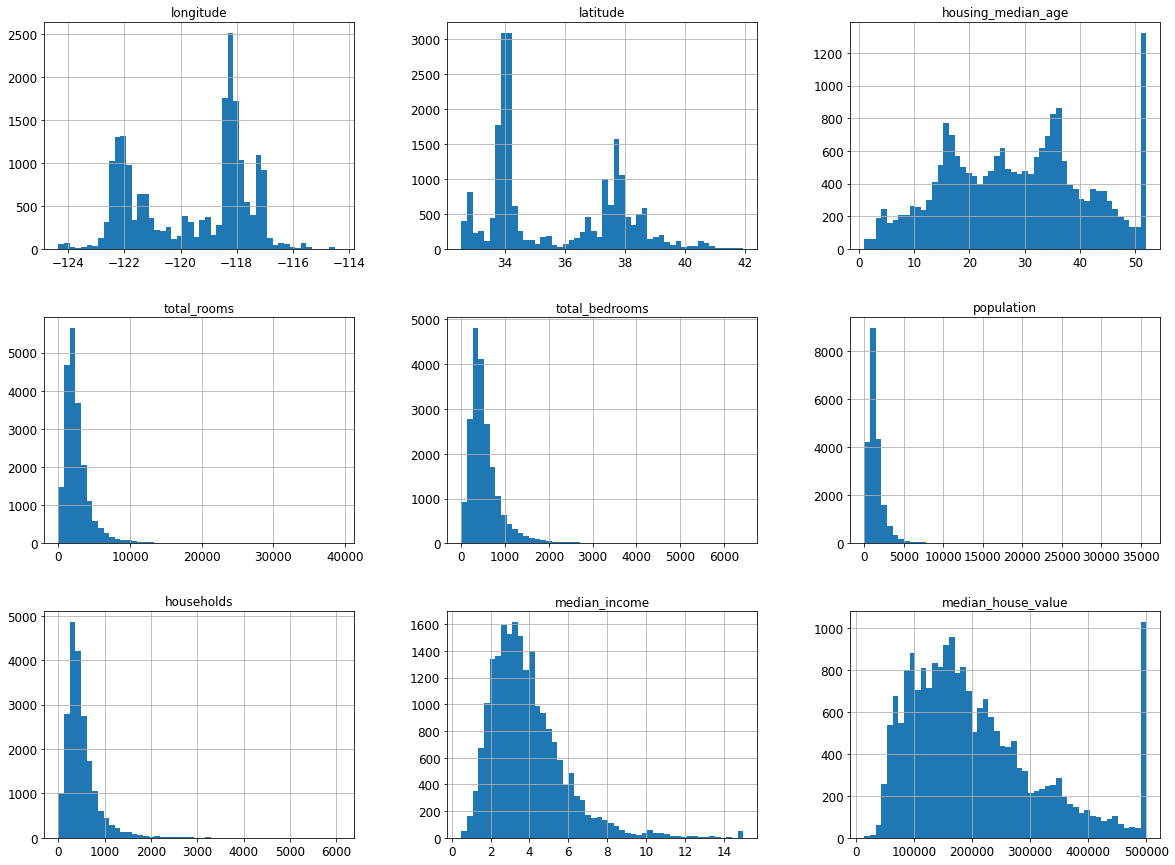

In [13]:
#Histogram of the numerical attributes

#inline only in jupyter notebook. set up Matplotlib so it uses Jupyter's own backend.
%matplotlib inline 

housing.hist(bins=50, figsize=(20,15))
plt.show()

#1. Median income not in US dollars. The data has been scaled and capped between 0.5 and 15.
#not really a problem for our model

#2, housing median age and median house value are capped.
#Problem since median house value is my response variable
#solutions : a) collect proper labels for capped district. b) remove capped districts from training set

#3 : very different scales between attributes

#many asymetries to the right. We will try to have bell-shaped distributions

In [15]:
#create a test set
from sklearn.model_selection import train_test_split

#random state is a seed
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

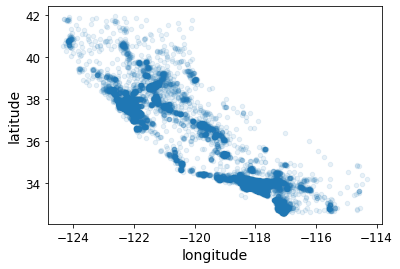

In [21]:
#Visualising data

#rename the train set
housing = strat_train_set.copy()

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


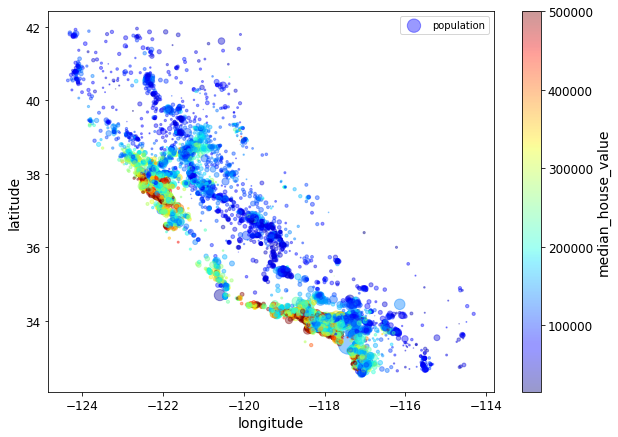

In [23]:
# s- radius of circle = district population, c- color = price cmap range from blue to red (low to high price)

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

In [25]:
#Looking at correlations

corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

#median_income has the best correlation

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

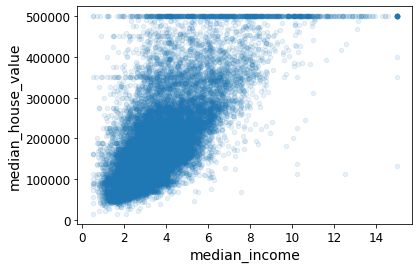

In [27]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

#problem with capping, also straight horizontal lines at 450 000 and 350 000

In [28]:
#create significative attribute combinations

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

#bedroom_per_room is more carrelated than total number of bedroom or number of room
#=> houses with lower bedroom-to-room ratio tend to be more expensive

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [31]:
#Prepare data for ml

housing = strat_train_set.drop("median_house_value", axis=1) # drop responsive variable for training set
housing_labels = strat_train_set["median_house_value"].copy()

#we saw that total_bedrooms has null variables. let's use imputer from sklearn : 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

#take only numerical attributes
housing_num = housing.drop("ocean_proximity", axis=1)

#replace missing values with the median
imputer.fit(housing_num)
X = imputer.transform(housing_num)

#X is a numPy array -> put it into pandas dt
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [34]:
#Handle categorical attribute : ocean_proximity

housing_cat = housing[["ocean_proximity"]]

#transform categories into encoded numerical values

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [35]:
#Combine Attributes Transformation (for sklearn we need implement fit(), transform() and fit_transform() for transformers)

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [36]:
#Standardize data and introduce pipeline transformer
#every object in pipeline must be a transformer except last estimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [37]:
#combine categorical and numerical data

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [38]:
#Select and train a linear regression model

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [39]:

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 86208. 304704. 153536. 185728. 244416.]


In [40]:
#comparison with the real labels
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [41]:
#measure model's RMSE

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

#prediction error of 68633 is not satisfying
#example of model underfitting the data -> not enough info to make good predictions OR model not powerful enough

68633.40810776998

In [42]:
#Let's try a DecisionTreeRegressor (capable of finding nonlinear relationships)

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [43]:
#Evaluation of DTR

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

#output 0 : overfit data

0.0

In [44]:
#Cross-validation

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [45]:
#C-V result
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

#Seems to perform worst than LR model
#Decision Tree overfit too much

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [50]:
#Let's try Random Forest Regressor model
#Average prediction from multiple Decision Trees

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

In [51]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

#much better results. But score on training set still much lower than on validation sets => model still overfitting

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [52]:
#Fine-Tune models With Grid Search 

from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

#tell which hyperparameters to experiment and what values to try out. Uses cross-validation
#to evaluate all combinations of hyperparameter values

#param_grid tells to first evaluate 3x4 combinations of n_estimators and max_features values in the first district
#then 2x3 combinations of values in second district

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [53]:
grid_search.best_params_
#best parameters combination

{'max_features': 8, 'n_estimators': 30}

In [55]:
#Evaluate system on the test set

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

47873.26095812988

In [56]:
#95% Confidence interval for generalization error

from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45893.36082829, 49774.46796717])